# Using Feat's archive

Feat optimizes a population of models. 
At the end of the run, it can be useful to explore this population to find a trade-off between objectives, 
such as performance and complexity. 

In this example, we apply Feat to a regression problem and visualize the archive of representations. 

Note: this code uses the Penn ML Benchmark Suite (https://github.com/EpistasisLab/penn-ml-benchmarks/) to fetch data. You can install it using `pip install pmlb`.


First, we import the data and create a train-test split.

In [1]:
from pmlb import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import numpy as np
# fix the random state
random_state=42
dataset='690_visualizing_galaxy'
X, y = fetch_data(dataset,return_X_y=True)
X_t,X_v, y_t, y_v = train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=random_state)

Then we set up a Feat instance and train the model, storing the final archive.

In [2]:
from feat import Feat


fest = Feat(pop_size=500,                                                                        
            gens=100,                  # maximum of 200 generations                            
            max_time=60,              # max time of 60 seconds                                                         
            max_depth=6,                    # constrain features to depth of 6                                                     
            max_dim=min([X.shape[1]*2,50]), # constrain representation dimensionality to 2x the feature space or 50                                                     
            random_state=random_state,                                                            
            hillclimb=True,                 # use stochastic hillclimbing to optimize weights for 10 iterations                                                  
            iters=10,                                                                            
            n_threads=1,                   # restricts to single thread                                                      
            verbosity=2,                   # verbose output                                                      
           ) 

print('FEAT version:', fest.__version__)
# train the model
fest.fit(X_t,y_t)

# get the test score
test_score = {}
test_score['feat'] = mse(y_v,fest.predict(X_v))

# store the archive
archive = fest.get_archive(justfront=True)

# print the archive
print('complexity','fitness','validation fitness',
     'eqn')
order = np.argsort([a['complexity'] for a in archive])
complexity = []
fit_train = []
fit_test = []
eqn = []

for o in order:
    model = archive[o]
    if model['pareto_rank'] == 1:
        print(model['complexity'],
              model['fitness'],
              model['fitness_v'],
              model['eqn'],
             )

        complexity.append(model['complexity'])
        fit_train.append(model['fitness'])
        fit_test.append(model['fitness_v'])
        eqn.append(model['eqn'])

FEAT version: 0.4.post37
complexity fitness validation fitness eqn
1.0 1804.71 1815.93 [x_1]
2.0 967.038 1090.61 [x_0][x_1]
3.0 931.526 916.835 [x_1][x_3][x_0]
4.0 912.518 862.106 [x_0][x_1][x_3][x_2]
6.0 825.652 835.325 [NOT((x_0<0.022626))][x_1]
7.0 467.786 665.829 [tanh(x_1)][x_0]
8.0 424.307 513.349 [tanh(x_1)][x_3][x_0]
10.0 386.612 466.544 [tanh(x_1)][x_3][(x_2+x_0)]
11.0 375.25 455.531 [x_3][tanh(x_1)][x_1][x_0][x_2][x_1]
12.0 350.893 499.175 [tanh(x_0)][tanh(x_1)]
13.0 320.283 427.11 [tanh(x_0)][tanh(x_1)][x_2]
14.0 302.621 373.354 [tanh(x_0)][tanh(x_1)][x_2][x_3]
16.0 298.695 373.749 [x_1][tanh(x_1)][x_3][x_3][x_2][tanh(x_0)]
17.0 290.61 431.343 [tanh(x_0)][tanh(x_1)][x_2][(x_3<0.775635)]
18.0 272.12 384.432 [tanh(x_0)][tanh(x_1)][x_2][x_3][(x_1<-0.789056)]
21.0 270.71 543.846 [tanh(x_0)][tanh(x_1)][x_1][relu(x_1)][(x_3<-1.687642)]
22.0 257.992 525.953 [sin(x_1)][tanh(x_0)][x_1][x_3][sqrt(|x_1|)][(x_1<1.816810)]
23.0 249.726 442.731 [relu(x_1)][tanh(x_1)][x_1][tanh(x_0)][x_2][

For comparison, we can fit an Elastic Net and Random Forest regression model to the same data.


In [3]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=random_state)

rf.fit(X_t,y_t)

test_score['rf'] = mse(y_v,rf.predict(X_v))


In [4]:
from sklearn.linear_model import ElasticNet

linest = ElasticNet()

linest.fit(X_t,y_t)

test_score['elasticnet'] = mse(y_v,linest.predict(X_v))


Let's look at the test set mean squared errors by method.

In [5]:
test_score

{'feat': 246.9783422805277,
 'rf': 347.15749506172847,
 'elasticnet': 919.3515337699562}

## Visualizing the Archive

Let's visualize this archive with the test scores. This gives us a sense of how increasing the representation
complexity affects the quality of the model and its generalization.


best: 60.0
middle: 14.0
small: 3.0
complexity [1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 10.0, 11.0, 12.0, 13.0, 14.0, 16.0, 17.0, 18.0, 21.0, 22.0, 23.0, 24.0, 25.0, 27.0, 30.0, 31.0, 33.0, 34.0, 50.0, 51.0, 54.0, 56.0, 60.0, 71.0, 85.0, 95.0, 98.0, 99.0, 102.0, 108.0]


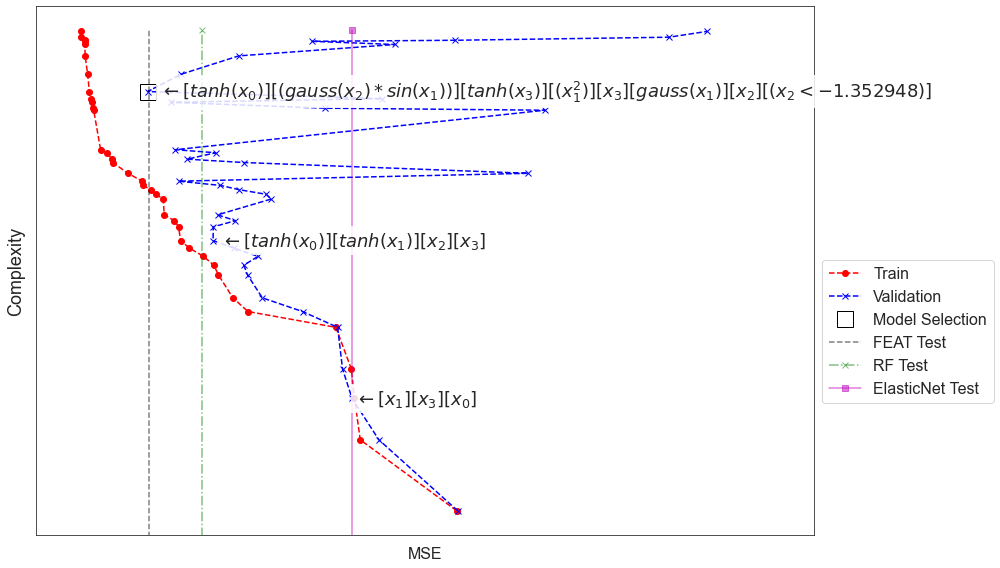

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

matplotlib.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline 
sns.set_style('white')
h = plt.figure(figsize=(14,8))

# plot archive points 
plt.plot(fit_train,complexity,'--ro',label='Train',markersize=6)
plt.plot(fit_test,complexity,'--bx',label='Validation')
# some models to point out
best = np.argmin(np.array(fit_test))
middle = np.argmin(np.abs(np.array(fit_test[:best])-test_score['rf']))
small = np.argmin(np.abs(np.array(fit_test[:middle])-test_score['elasticnet']))

print('best:',complexity[best])
print('middle:',complexity[middle])
print('small:',complexity[small])
plt.plot(fit_test[best],complexity[best],'sk',markersize=16,markerfacecolor='none',label='Model Selection')

# test score lines
y1 = -1
y2 = np.max(complexity)+1
plt.plot((test_score['feat'],test_score['feat']),(y1,y2),'--k',label='FEAT Test',alpha=0.5)
plt.plot((test_score['rf'],test_score['rf']),(y1,y2),'-.xg',label='RF Test',alpha=0.5)
plt.plot((test_score['elasticnet'],test_score['elasticnet']),(y1,y2),'-sm',label='ElasticNet Test',alpha=0.5)

print('complexity',complexity)
xoff = 20
for e,t,c in zip(eqn,fit_test,complexity):
    if c in [complexity[best],complexity[middle],complexity[small]]:
        t = t+xoff
        tax = plt.text(t,c,'$\leftarrow'+e+'$',size=18,horizontalalignment='left',
                      verticalalignment='center')
        tax.set_bbox(dict(facecolor='white', alpha=0.85, edgecolor='none'))

l = plt.legend(prop={'size': 16},loc=[1.01,0.25])
plt.xlabel('MSE',size=16)
plt.xlim(np.min(fit_train)*.75,np.max(fit_test)*2)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.gca().set_yticklabels('')
plt.gca().set_xticklabels('')

plt.ylabel('Complexity',size=18)
h.tight_layout()

plt.show()

Note that ElasticNet produces a similar test score to the linear representation
in Feat's archive, and that Random Forest's test score is near the representation shown in the middle.

The best model, marked with a square, is selected from the validation curve (blue line).
The validation curve shows how models begin to overfit as complexity grows.
By visualizing the archive, we can see that some lower complexity models achieve nearly as good of a validation score.
In this case it may be preferable to choose that representation instead.

By default, FEAT will choose the model with the lowest validation error, marked with a square above. 
Let's look at that model.

the function `get_model()` will print a table of the learned features, ordered by the magnitude of their weights.

In [7]:
print(fest.get_model())

Feature		Weight
offset		1588.25
tanh(x_1)		-99.060867
(x_2*x_1)		-90.169205
tanh(x_0)		-60.198231
(exp(x_1)-((x_1^2)^3))		-38.990429
(x_0*x_2)		-32.088799
tanh(x_0)		27.651752
x_3		-17.219564
logit(x_2)		-2.558559

